In [1]:
import torch
import torchvision
import torchvision.datasets
import torchvision.transforms
import torch.utils.data
import torch.nn
import os
import numpy as np
from matplotlib import pyplot as plot
from time import perf_counter

Количество тренировочных примеров: 60000
Количество тестовых примеров: 10000


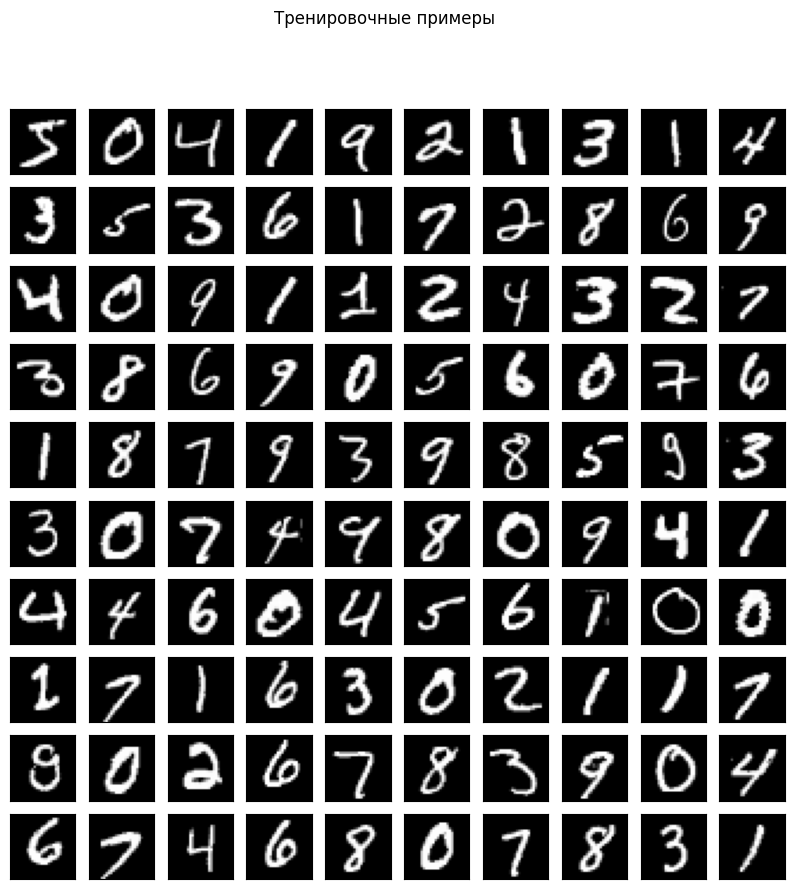

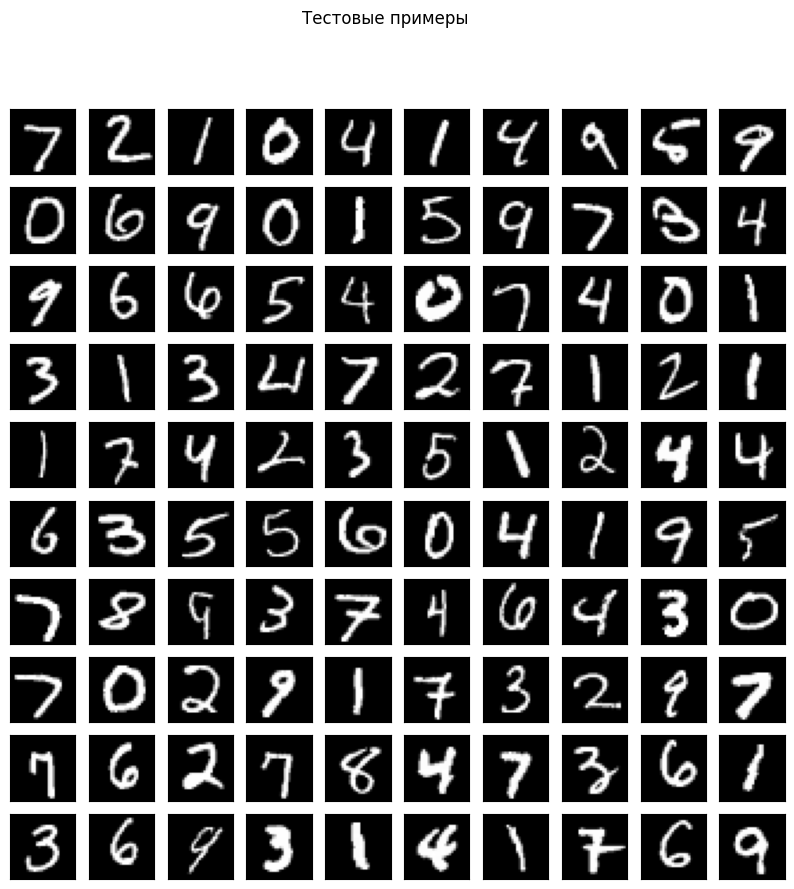

In [2]:
# функция для вывода изображений
def show_images(images, title):
    num = 10
    figsize = (num, num)
    fig, axes = plot.subplots(num, num, figsize = figsize)
    fig.suptitle(title)
    plot.setp(plot.gcf().get_axes(), xticks = [], yticks = [])
    for i, ax in enumerate(axes.flat):
        img = images[i][0].numpy().transpose(1, 2, 0).squeeze(axis = 2)
        # проверка размеров
        if np.shape(img) != (28, 28):
            print("Размеры данных не 28х28!")
            return
        ax.imshow(img, cmap = "gray")

# скачивание данных в текущую директорию
dir_name = os.getcwd()

# чтение тренировочной выборки MNITS
train_dataset = torchvision.datasets.MNIST(root = dir_name, train = True, download = True, transform = torchvision.transforms.ToTensor())
# чтение тестовой выборки MNITS
test_dataset = torchvision.datasets.MNIST(root = dir_name, train = False, download = True, transform = torchvision.transforms.ToTensor())

print("Количество тренировочных примеров: " + str(len(train_dataset)))
show_images(train_dataset, "Тренировочные примеры")
print("Количество тестовых примеров: " + str(len(test_dataset)))
show_images(test_dataset, "Тестовые примеры")
      

# Модель на основе Torch

In [3]:
# размер обрабатываемой пачки данных (по усл, от 8 до 64)
batch_size = 64

# создание объектов для последовательой загрузки пачек из выборок
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

# создание модели
N = 28 * 28 # кол-во входных нейронов
M = 10      # кол-во выходных нейронов
S = 300     # кол-во скрытых слоёв

# создание класса сети
class LogisticRegressionModel(torch.nn.Module):
    # конструктор
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LogisticRegressionModel, self).__init__()
        
        # создание 1 полносвязного слоя
        self.linear1 = torch.nn.Linear(input_dim, hidden_dim)
        # функция активации на скрытом слое
        self.relu = torch.nn.ReLU()
        # создание 2 полносвязного слоя
        self.linear2 = torch.nn.Linear(hidden_dim, output_dim)
    
    # переопределение метода, вызываемого в процессе прямого прохода
    def forward(self, x):
        out = self.linear1(x)
        out = self.relu(out)
        out = self.linear2(out)
        return out

# создание объекта разработанного класса
logreg_nn = LogisticRegressionModel(N, S, M)

In [4]:
# обучение построенной модели на CPU

learning_rate = 0.1  # скорость обучения
num_epochs = 20      # кол-во эпох

# выбор устройства для вычислений
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
logreg_nn.to(device)

# функция ошибки на этапе обучения - кросс-энтропия
loss_function = torch.nn.CrossEntropyLoss()

# метод оптимизации для обучения параметров - стохастический градиентный спуск
optimizer = torch.optim.SGD(logreg_nn.parameters(), lr = learning_rate)

# функция top-1
def get_accuracy(data_loader, model):
    TP = 0     # True-Positive
    count = 0  # число изображений
    with torch.no_grad(): # деактивация вычисления градиентов
        # проход по всем данным
        for images, labels in data_loader:
            # преобразование тензора [B, C, W, H] к формату [B, W * H]
            images = images.reshape(-1, N)
            # выход сети
            outputs = model(images)
            
            # выбор максимальных значений по первой размерности
            _, predicted = torch.max(outputs.data, 1)
            # кол-во изображений
            count += labels.size(0)
            # кол-во совпадений
            TP += (predicted == labels).sum()
    return TP / count

# проход по эпохам
for epoch in range(num_epochs):
    # время для эпохи
    epoch_time = perf_counter()
    for i, (images, labels) in enumerate(train_data_loader):
        # преобразование тензора [B, C, W, H] к формату [B, W * H]
        # и отправка данных на устройство
        images = images.view(-1, N).requires_grad_().to(device)
        labels = labels.to(device)
        
        # прямой проход
        # вычисление выхода сети
        outputs = logreg_nn(images)
        # вычисление ошибки
        loss = loss_function(outputs, labels)
        
        # обратный проход
        # обнуление всех вычисляемых градиентов и вычисление градиента фукнции ошибки
        optimizer.zero_grad()
        loss.backward()
        # обновление параметров модели
        optimizer.step()
    
    epoch_time = perf_counter() - epoch_time
    # точность для эпохи
    accuracy = get_accuracy(train_data_loader, logreg_nn)
    print("Эпоха " + str(epoch) + ", точность = " + str(accuracy) + ", время = " + str(epoch_time))

# Тестирование обученной модели
accuracy = get_accuracy(test_data_loader, logreg_nn)
print("Тестовая точность = " + str(accuracy))

Эпоха 0, точность = tensor(0.9239), время = 6.648164299986092
Эпоха 1, точность = tensor(0.9508), время = 6.067097099992679
Эпоха 2, точность = tensor(0.9621), время = 6.574249299999792
Эпоха 3, точность = tensor(0.9671), время = 6.5430255999963265
Эпоха 4, точность = tensor(0.9738), время = 6.456463500013342
Эпоха 5, точность = tensor(0.9792), время = 6.678741700015962
Эпоха 6, точность = tensor(0.9808), время = 6.366171100002248
Эпоха 7, точность = tensor(0.9842), время = 6.023683300008997
Эпоха 8, точность = tensor(0.9861), время = 6.020864299993264
Эпоха 9, точность = tensor(0.9883), время = 6.045076400012476
Эпоха 10, точность = tensor(0.9876), время = 5.983660300000338
Эпоха 11, точность = tensor(0.9903), время = 5.946903300005943
Эпоха 12, точность = tensor(0.9909), время = 6.035150899988366
Эпоха 13, точность = tensor(0.9911), время = 6.019460800016532
Эпоха 14, точность = tensor(0.9931), время = 5.97269269998651
Эпоха 15, точность = tensor(0.9946), время = 5.950912000000244
Эп

# Собственная модель

In [5]:
def relu(x):
    return torch.mul(x, x > 0)

def reludif(x):
    return x.bool().float()

def softmax(x):
    return torch.softmax(x, 1)

# создание класса сети
class MyModel():
    # конструктор
    def __init__(self, input_dim, hidden_dim, output_dim, batch_size, learning_rate):
        self.N = input_dim
        self.S = hidden_dim
        self.M = output_dim
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        
        # инициалиация весов
        self.weights = self.init_weights()
    
    def init_weights(self):
        # Синаптические веса генерируются
        # Внешнее воздействие - нулевое
        w1 = torch.zeros((self.S, self.N)) # матрица SxN
        torch.nn.init.xavier_normal_(w1)
        b1 = torch.zeros((self.S, 1))      # матрица Sx1
        w2 = torch.zeros((self.M, self.S)) # матрица MxS
        torch.nn.init.xavier_normal_(w2)
        b2 = torch.zeros((self.M, 1))      # матрица Mx1
        return {"w1" : w1, "b1" : b1, "w2" : w2, "b2" : b2}
    
    # прямой проход
    def forward(self, x):
        #print("input = " +str(x.shape))
        self.input = x
        
        # BSxN x NxS + 1xS = BSxS
        self.v = x @ self.weights["w1"].transpose(0, 1) + self.weights["b1"].transpose(0, 1) 
        self.rv = relu(self.v)
        
        # BSxS x SxM + 1xM = BSxM
        self.u = self.rv @ self.weights["w2"].transpose(0, 1) + self.weights["b2"].transpose(0, 1)
        self.sm = softmax(self.u)
        
        return self.sm

    # обратный проход
    def backward(self, labels):        
        new_labels = torch.zeros_like(self.sm)
        for i in range(labels.shape[0]):
            new_labels[i, labels[i]] = 1
        #print(new_labels.shape)
        
        delta_u = (self.sm - new_labels) / labels.shape[0]
        dw2 = delta_u.transpose(0, 1) @ self.rv
 
        delta_v = torch.mul(delta_u @ self.weights["w2"], self.v > 0)
        dw1 = delta_v.transpose(0, 1) @ self.input
        
        self.weights["w1"] -= self.learning_rate * dw1
        self.weights["w2"] -= self.learning_rate * dw2
        self.weights["b1"] -= self.learning_rate * delta_v.sum(0).unsqueeze(-1)
        self.weights["b2"] -= self.learning_rate * delta_u.sum(0).unsqueeze(-1)
        
        return
    
    def __call__(self, images):
        return self.forward(images)

In [6]:
nn = MyModel(N, S, M, batch_size, learning_rate)

# проход по эпохам
for epoch in range(20):
    # время для эпохи
    epoch_time = perf_counter()
    for i, (images, labels) in enumerate(train_data_loader):
        # преобразование тензора [B, C, W, H] к формату [B, W * H]
        # и отправка данных на устройство
        images = images.view(-1, N).requires_grad_().to(device)
        labels = labels.to(device)
        
        # прямой проход
        nn.forward(images)
        
        # обратный проход
        nn.backward(labels)
    
    epoch_time = perf_counter() - epoch_time
    # точность для эпохи
    accuracy = get_accuracy(train_data_loader, nn)
    print("Эпоха " + str(epoch) + ", точность = " + str(accuracy) + ", время = " + str(epoch_time))

# Тестирование обученной модели
accuracy = get_accuracy(test_data_loader, nn)
print("Тестовая точность = " + str(accuracy))

Эпоха 0, точность = tensor(0.9350), время = 6.248600299993996
Эпоха 1, точность = tensor(0.9557), время = 6.250063199986471
Эпоха 2, точность = tensor(0.9681), время = 6.279147699999157
Эпоха 3, точность = tensor(0.9731), время = 6.663860600005137
Эпоха 4, точность = tensor(0.9788), время = 6.310189900017576
Эпоха 5, точность = tensor(0.9820), время = 6.36056760000065
Эпоха 6, точность = tensor(0.9841), время = 6.458125800010748
Эпоха 7, точность = tensor(0.9860), время = 6.3440356999926735
Эпоха 8, точность = tensor(0.9878), время = 6.4895008000021335
Эпоха 9, точность = tensor(0.9895), время = 6.5059087999979965
Эпоха 10, точность = tensor(0.9910), время = 6.381878499989398
Эпоха 11, точность = tensor(0.9922), время = 6.423079000000143
Эпоха 12, точность = tensor(0.9935), время = 6.321825299994089
Эпоха 13, точность = tensor(0.9938), время = 6.408930800011149
Эпоха 14, точность = tensor(0.9943), время = 6.632471699995222
Эпоха 15, точность = tensor(0.9946), время = 6.603767099994002
